In [2]:
import pandas as pd

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
data = pd.read_csv('../data/data_balita.csv')
data.head() 

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


- Umur (Bulan): Mengindikasikan usia balita dalam bulan. Rentang usia ini penting untuk menentukan fase pertumbuhan anak dan membandingkannya dengan standar pertumbuhan yang sehat.

- Jenis Kelamin: Terdapat dua kategori dalam kolom ini, 'laki-laki' dan 'perempuan'. Jenis kelamin merupakan faktor penting dalam analisis pola pertumbuhan dan risiko stunting.

- Tinggi Badan: Dicatat dalam centimeter, tinggi badan adalah indikator utama untuk menilai pertumbuhan fisik balita. Data ini memungkinkan peneliti untuk menentukan apakah pertumbuhan anak sesuai dengan standar usianya.

- Status Gizi: Kolom ini dikategorikan menjadi 4 status - 'severely stunting', 'stunting', 'normal', dan 'tinggi'. 'Severely stunting' menunjukkan kondisi sangat serius, 'stunting' menunjukkan kondisi stunting, 'normal' mengindikasikan status gizi yang sehat, dan 'tinggi' menunjukkan pertumbuhan di atas rata-rata. Kategori ini membantu dalam identifikasi cepat dan intervensi bagi anak-anak yang berisiko atau mengalami masalah pertumbuhan.

In [35]:
data['Jenis Kelamin'] = data['Jenis Kelamin'].map({"perempuan":0, "laki-laki":1})


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Status Gizi'] = le.fit_transform(data['Status Gizi'])

In [18]:
print(le.classes_)

['normal' 'severely stunted' 'stunted' 'tinggi']


In [17]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,2
1,0,laki-laki,56.705203,3
2,0,laki-laki,46.863358,0
3,0,laki-laki,47.508026,0
4,0,laki-laki,42.743494,1
...,...,...,...,...
120994,60,perempuan,100.600000,0
120995,60,perempuan,98.300000,2
120996,60,perempuan,121.300000,0
120997,60,perempuan,112.200000,0


In [12]:
data['Jenis Kelamin'].value_counts()

Jenis Kelamin
perempuan    61002
laki-laki    59997
Name: count, dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Umur (bulan),120999.0,30.173803,17.575119,0.000000,15.0,30.0,45.0,60.0
Tinggi Badan (cm),120999.0,88.655434,17.300997,40.010437,77.0,89.8,101.2,128.0


In [10]:
data['Status Gizi'].value_counts()

Status Gizi
normal              67755
severely stunted    19869
tinggi              19560
stunted             13815
Name: count, dtype: int64

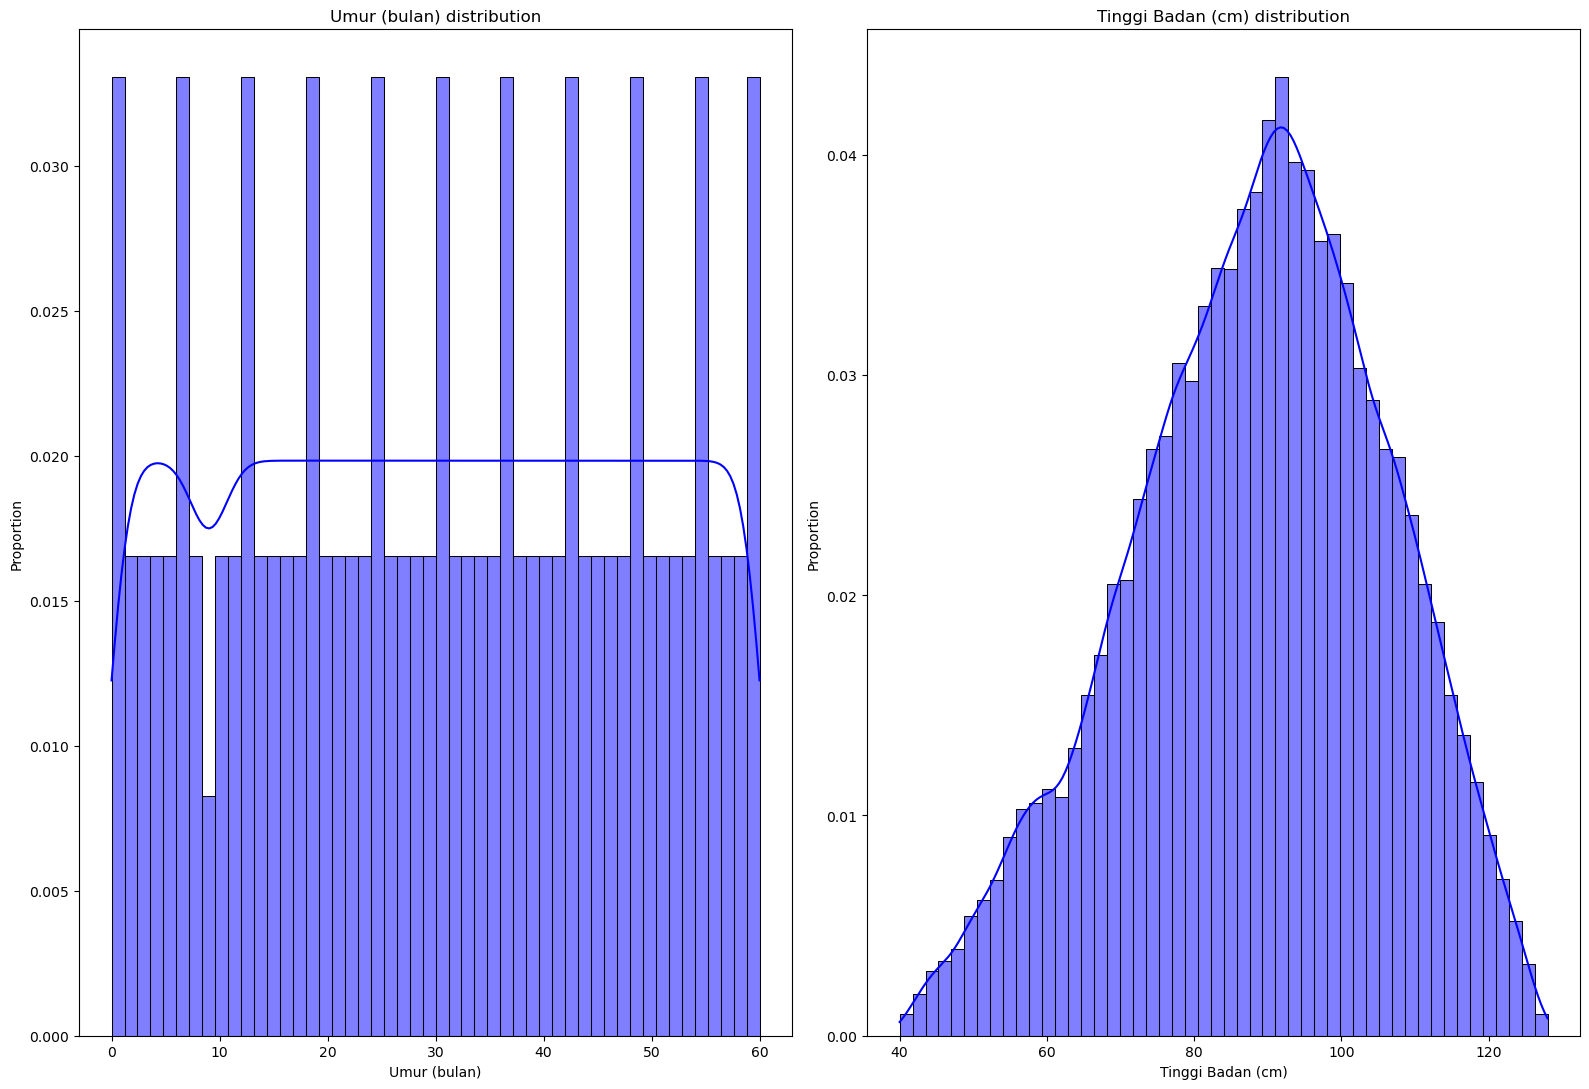

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


num_features = ["Umur (bulan)", "Tinggi Badan (cm)"]

fig, axes = plt.subplots(1,2, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.histplot(data[feature], bins=50, stat="proportion",kde=True, color='blue', ax=ax)
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

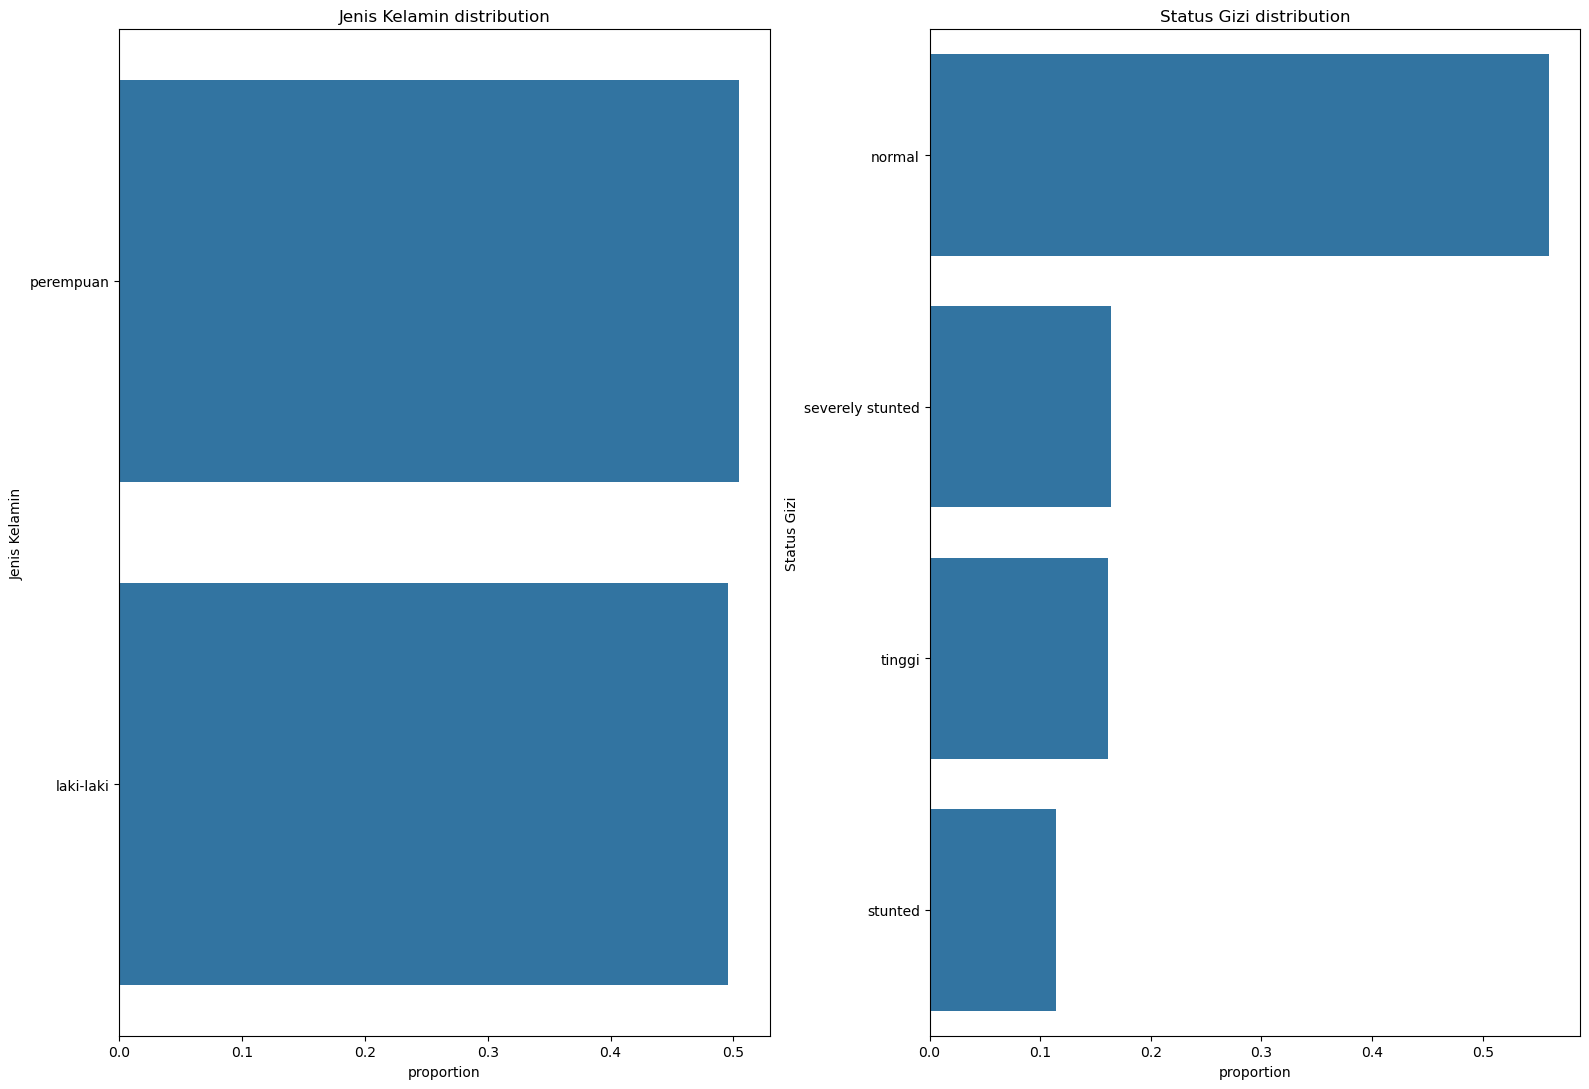

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 11))

cat_feature = ["Jenis Kelamin", "Status Gizi"]
for ax, feature in zip(axes.flat, cat_feature):
    vc = data[feature].value_counts(normalize=True)
    sns.barplot(x=vc.values,y=vc.index,ax=ax,orient='h')

    ax.set_xlabel("proportion")
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} distribution")



plt.tight_layout()
plt.show()

In [19]:
def check_outliers(data, features):
    outlier_counts = {}
    total_outlier = 0
    for feat in features:
        Q1 = data[feat].quantile(0.25)
        Q3 = data[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_cound = Q3 + 1.5 * IQR
        feature_outlier = data[(data[feat] < lower_bound) | (data[feat] > upper_cound)]
        outlier_count = len(feature_outlier)
        outlier_counts[feat] = outlier_count
        total_outlier += outlier_count
    print(f"There are {total_outlier} outliers in the dataset")
    print()
    print("Outlier Percentage Per feature")
    for feature, count in outlier_counts.items():
        print(f"{feature}: {count} ({round(count/len(data)*100,2)})%")

In [20]:
data.columns

Index(['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi'], dtype='object')

In [21]:
check_outliers(data, ['Umur (bulan)','Tinggi Badan (cm)'])

There are 38 outliers in the dataset

Outlier Percentage Per feature
Umur (bulan): 0 (0.0)%
Tinggi Badan (cm): 38 (0.03)%


In [36]:
X = data.drop(columns=['Status Gizi'])
y = data['Status Gizi']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [33]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,2
1,0,laki-laki,56.705203,3
2,0,laki-laki,46.863358,0
3,0,laki-laki,47.508026,0
4,0,laki-laki,42.743494,1
...,...,...,...,...
120994,60,perempuan,100.600000,0
120995,60,perempuan,98.300000,2
120996,60,perempuan,121.300000,0
120997,60,perempuan,112.200000,0


In [45]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.modeling_utils import * 
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }


# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

CustomException: An error occurred in python file [/Users/atharfathana/Documents/Machine Learning-AI/stunting-pred/src/modeling_utils.py] line number [543] error message [multi_class must be in ('ovo', 'ovr')]